In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
coindata = pd.read_csv('CoinMarketCapWebApp.csv')
googledata = pd.read_csv('GoogleVolume.csv')

In [5]:
coindata = coindata.drop(['#'], axis=1)
coindata.columns = ['Date','Open','High','Low','Close','Volume']
googledata = googledata.drop(['Date','#'], axis=1)

In [6]:
last = pd.concat([coindata,googledata], axis=1)

In [8]:
last.to_csv('Bitcoin3D.csv', index=False)

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import dot

In [14]:

def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [16]:
df = pd.read_csv("Bitcoin1D.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.reindex(index= df.index[::-1])

In [17]:
zaman = np.arange(1, len(df) + 1, 1)
OHCL_avg = df.mean(axis=1)

In [18]:
OHCL_avg = np.reshape(OHCL_avg.values, (len(OHCL_avg),1)) #7288 data
scaler = MinMaxScaler(feature_range=(0,1))
OHCL_avg = scaler.fit_transform(OHCL_avg)

In [20]:
#print(OHCL_avg)
train_OHLC = int(len(OHCL_avg)*0.56)
test_OHLC = len(OHCL_avg) - train_OHLC
train_OHLC, test_OHLC = OHCL_avg[0:train_OHLC,:], OHCL_avg[train_OHLC:len(OHCL_avg),:]
#Train the datasets and test it
trainX, trainY = new_dataset(train_OHLC,1)
testX, testY = new_dataset(test_OHLC,1)

In [21]:
trainX = np.reshape(trainX, (trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1]))
step_size = 1

In [23]:
model = Sequential()
model.add(LSTM(128, input_shape=(1, step_size)))
model.add(Dropout(0.1))
model.add(Dense(1))
model.add(Activation('linear'))

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=25, verbose=2)

Epoch 1/10
537/537 - 2s - loss: 0.0101
Epoch 2/10
537/537 - 1s - loss: 2.7073e-04
Epoch 3/10
537/537 - 1s - loss: 2.3575e-04
Epoch 4/10
537/537 - 1s - loss: 2.0943e-04
Epoch 5/10
537/537 - 1s - loss: 1.9394e-04
Epoch 6/10
537/537 - 1s - loss: 1.8694e-04
Epoch 7/10
537/537 - 1s - loss: 1.6827e-04
Epoch 8/10
537/537 - 1s - loss: 1.5626e-04
Epoch 9/10
537/537 - 1s - loss: 1.4607e-04
Epoch 10/10
537/537 - 1s - loss: 1.3686e-04


In [26]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [27]:
trainScore = math.sqrt(mean_squared_error(trainY[0], 
                       trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], 
                       testPredict[:,0]))

In [29]:
trainPredictPlot = np.empty_like(OHCL_avg)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size,:] = trainPredict

In [30]:
testPredictPlot = np.empty_like(OHCL_avg)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHCL_avg)-1,:] = testPredict

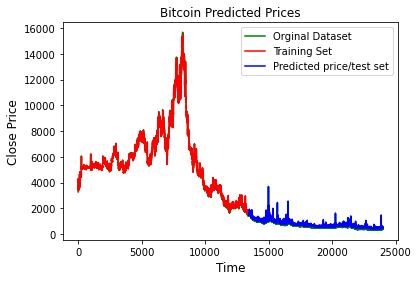

In [32]:
OHCL_avg = scaler.inverse_transform(OHCL_avg)
plt.plot(OHCL_avg, 'g', label='Orginal Dataset')
plt.plot(trainPredictPlot, 'r', label='Training Set')
plt.plot(testPredictPlot, 'b', label='Predicted price/test set')
plt.title("Bitcoin Predicted Prices")
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(loc='upper right')
plt.show()